In [2]:
import sys
from pathlib import Path

project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

print("Project root set to:", project_root)


Project root set to: f:\projects\marketing


In [3]:
from src.config import get_paths
from src.IO import write_parquet
paths = get_paths(project_root)
paths

Paths(root=WindowsPath('F:/projects/marketing'), raw=WindowsPath('F:/projects/marketing/data/raw'), processed=WindowsPath('F:/projects/marketing/data/processed'))

In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [5]:
from src.IO import read_csv

orders = read_csv(paths.raw / "olist_orders_dataset.csv")
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


### Orders table: column relevance for marketing budget reallocation

The following columns are required for the analysis:
- `order_id`: primary key, required for joins and aggregation
- `customer_id`: required to link orders to customers
- `order_purchase_timestamp`: required for cohorting, recency, and tenure
- `order_status`: required to interpret nulls and exclude canceled orders if needed

The following columns are **not used** in downstream analysis:
- `order_approved_at`: operational timestamp, not relevant to marketing decisions
- `order_delivered_carrier_date`: logistics-related, no impact on acquisition or retention strategy
- `order_delivered_customer_date`: delivery performance, not used for CLV or budget allocation
- `order_estimated_delivery_date`: planning metadata, not required for this analysis

These columns are retained in raw data but excluded from the analytical dataset to reduce noise and focus on decision-relevant features.


In [6]:
orders.shape

(99441, 8)

In [7]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


### Missing values assessment (orders table)

The following columns contain missing values:

- `order_approved_at`: 160 missing values (~0.16%)
- `order_delivered_carrier_date`: 1,783 missing values (~1.79%)
- `order_delivered_customer_date`: 2,965 missing values (~2.98%)

These missing values represent a small fraction of the dataset and are likely related to
orders that were canceled or not fully processed.  
At this stage, rows with missing values are **retained** to avoid prematurely removing
potentially meaningful business events. Handling of these nulls will be informed by
`order_status` during later analysis.

No missing values are present in:
- `order_id`
- `customer_id`
- `order_status`
- `order_purchase_timestamp`
- `order_estimated_delivery_date`


### Data type assessment

All columns in the orders table are currently stored as `object` dtype.

The following columns represent timestamps and should be converted to `datetime`:

- `order_purchase_timestamp`
- `order_approved_at`
- `order_delivered_carrier_date`
- `order_delivered_customer_date`
- `order_estimated_delivery_date`

Converting these columns to datetime is required to support:
- time-based analysis (cohorting, recency, tenure)
- correct handling of missing values
- reliable downstream CLV calculations

Data type conversion will be performed using `pd.to_datetime` with coercion to handle
any invalid or malformed values safely.


In [8]:
datetime_cols = [
    "order_purchase_timestamp",
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date",
]

for col in datetime_cols:
    orders[col] = pd.to_datetime(orders[col], errors="coerce")


In [9]:
orders.duplicated().sum()

np.int64(0)

In [10]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB


In [11]:
orders[(orders['order_delivered_customer_date'].isnull()) &
       (orders['order_status'] == 'delivered')]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
3002,2d1e2d5bf4dc7227b3bfebb81328c15f,ec05a6d8558c6455f0cbbd8a420ad34f,delivered,2017-11-28 17:44:07,2017-11-28 17:56:40,2017-11-30 18:12:23,NaT,2017-12-18
20618,f5dd62b788049ad9fc0526e3ad11a097,5e89028e024b381dc84a13a3570decb4,delivered,2018-06-20 06:58:43,2018-06-20 07:19:05,2018-06-25 08:05:00,NaT,2018-07-16
43834,2ebdfc4f15f23b91474edf87475f108e,29f0540231702fda0cfdee0a310f11aa,delivered,2018-07-01 17:05:11,2018-07-01 17:15:12,2018-07-03 13:57:00,NaT,2018-07-30
79263,e69f75a717d64fc5ecdfae42b2e8e086,cfda40ca8dd0a5d486a9635b611b398a,delivered,2018-07-01 22:05:55,2018-07-01 22:15:14,2018-07-03 13:57:00,NaT,2018-07-30
82868,0d3268bad9b086af767785e3f0fc0133,4f1d63d35fb7c8999853b2699f5c7649,delivered,2018-07-01 21:14:02,2018-07-01 21:29:54,2018-07-03 09:28:00,NaT,2018-07-24
92643,2d858f451373b04fb5c984a1cc2defaf,e08caf668d499a6d643dafd7c5cc498a,delivered,2017-05-25 23:22:43,2017-05-25 23:30:16,NaT,NaT,2017-06-23
97647,ab7c89dc1bf4a1ead9d6ec1ec8968a84,dd1b84a7286eb4524d52af4256c0ba24,delivered,2018-06-08 12:09:39,2018-06-08 12:36:39,2018-06-12 14:10:00,NaT,2018-06-26
98038,20edc82cf5400ce95e1afacc25798b31,28c37425f1127d887d7337f284080a0f,delivered,2018-06-27 16:09:12,2018-06-27 16:29:30,2018-07-03 19:26:00,NaT,2018-07-19


### Interpretation of missing delivery dates

Missing values in delivery-related timestamp columns are strongly associated with
orders that were not successfully delivered (e.g. canceled or unavailable orders).

When filtering for `order_status == "delivered"`, only 8 rows contain missing
delivery timestamps, representing a negligible fraction of the dataset.

Conclusion:
- Missing delivery timestamps are treated as valid indicators of incomplete orders
- Rows are retained
- Order inclusion/exclusion will be handled explicitly using `order_status`


In [12]:
orders['order_status'].value_counts()

order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: count, dtype: int64

### Order status filtering for marketing analysis

Order status distribution shows that the majority of orders are marked as `delivered`,
with a smaller number of orders in `shipped`, `approved`, `canceled`, and other states.

For the purposes of marketing budget reallocation, only orders that represent completed
or near-completed customer experiences are included in behavioral analysis.

Included statuses:
- `delivered`
- `shipped` (treated as delivered due to high likelihood of completion)

Excluded statuses:
- `approved`
- `canceled`
- `unavailable`
- other non-completed states

Rationale:
Marketing and CLV analysis require evidence of actual customer consumption.
Orders that did not reach the customer are excluded to avoid biasing repeat behavior
and lifetime value estimates.


In [13]:
valid_statuses = ["delivered", "shipped"]

orders_valid = orders[orders["order_status"].isin(valid_statuses)].copy()


In [14]:
orders_valid['order_status'].value_counts()

order_status
delivered    96478
shipped       1107
Name: count, dtype: int64

In [54]:
orders_valid.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [55]:
orders_final = orders_valid.drop(columns=["order_approved_at","order_delivered_carrier_date"])

In [56]:
orders_final.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-16 18:17:02,2018-02-26


In [58]:
write_parquet(
    orders_final,
    project_root / "data" / "interim" / "orders_final.parquet"
)

In [16]:
customers = read_csv(paths.raw / "olist_customers_dataset.csv")
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [17]:
customers.shape

(99441, 5)

In [18]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [19]:
customers.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [20]:
customers.duplicated().sum()

np.int64(0)

In [21]:
customers['customer_city'].value_counts()

customer_city
sao paulo                   15540
rio de janeiro               6882
belo horizonte               2773
brasilia                     2131
curitiba                     1521
                            ...  
olhos d'agua                    1
pacotuba                        1
sao sebastiao do paraiba        1
benedito leite                  1
campos verdes                   1
Name: count, Length: 4119, dtype: int64

In [22]:
customers['customer_city'].nunique()

4119

In [ ]:
customers["customer_city_clean"] = (
    customers["customer_city"]
    .str.lower()
    .str.strip()
    .str.normalize("NFKD")
    .str.encode("ascii", errors="ignore")
    .str.decode("utf-8")
)

In [60]:
customers["customer_state"].nunique()

27

`customer_state` contains 27 unique values, matching the expected number of Brazilian
states. No normalization is required, and the column is used as the primary geographic
dimension in the analysis.


`customer_city` is not used in the final analysis. City-level data is too granular for
marketing budget decisions, so analysis is done at the state level. The column is kept
for optional exploratory use.


In [62]:
customers_final = customers.drop(columns=["customer_city","customer_zip_code_prefix"])

In [70]:
customers_final.rename(columns={"customer_city_clean": "customer_city"}, inplace=True)


In [71]:
customers_final.head()

,customer_id,customer_unique_id,customer_state,customer_city
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,SP,franca
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,SP,sao bernardo do campo
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,SP,sao paulo
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,SP,mogi das cruzes
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,SP,campinas


In [72]:
write_parquet(
  customers_final,
    project_root / "data" / "interim" / "customers_final.parquet"
)

In [73]:
order_items = read_csv(paths.raw / "olist_order_items_dataset.csv")

In [ ]:
order_items.head

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [76]:
order_items.shape
 

(112650, 7)

In [77]:
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [79]:
order_items["order_item_id"].value_counts()

order_item_id
1     98666
2      9803
3      2287
4       965
5       460
6       256
7        58
8        36
9        28
10       25
11       17
12       13
13        8
14        7
15        5
16        3
17        3
18        3
19        3
20        3
21        1
Name: count, dtype: int64

In [80]:
order_items.isna().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [81]:
order_items.duplicated().sum()  

np.int64(0)

Product- and seller-level fields are not used in this project. The analysis focuses on
customer behavior and order-level value for marketing budget decisions, so item-level
details are used only to compute aggregated order revenue.


In [82]:
order_items_final = order_items.drop(columns=["seller_id","shipping_limit_date","product_id"])

In [83]:
order_items_final.head()


,order_id,order_item_id,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,199.90,18.14


In [84]:
write_parquet(
  order_items_final,project_root / "data" / "interim" / "order_items_final.parquet")

In [85]:
order_payments = read_csv(paths.raw / "olist_order_payments_dataset.csv")

In [86]:
order_payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [87]:
order_payments.shape

(103886, 5)

In [88]:
order_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [89]:
order_payments.isna().sum()

order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

In [90]:
order_payments.duplicated().sum()

np.int64(0)

In [91]:
order_payments['payment_type'].value_counts()   

payment_type
credit_card    76795
boleto         19784
voucher         5775
debit_card      1529
not_defined        3
Name: count, dtype: int64

In [93]:
order_payments = order_payments[order_payments['payment_type'] != 'not_defined']

In [94]:
order_payments['payment_type'].value_counts()  

payment_type
credit_card    76795
boleto         19784
voucher         5775
debit_card      1529
Name: count, dtype: int64

In [95]:
order_payments.describe()

,payment_sequential,payment_installments,payment_value
count,103883.000000,103883.000000,103883.000000
mean,1.092681,2.853402,154.104831
std,0.706594,2.687071,217.495628
min,1.000000,0.000000,0.000000
25%,1.000000,1.000000,56.800000
50%,1.000000,1.000000,100.000000
75%,1.000000,4.000000,171.840000
max,29.000000,24.000000,13664.080000


<Axes: >

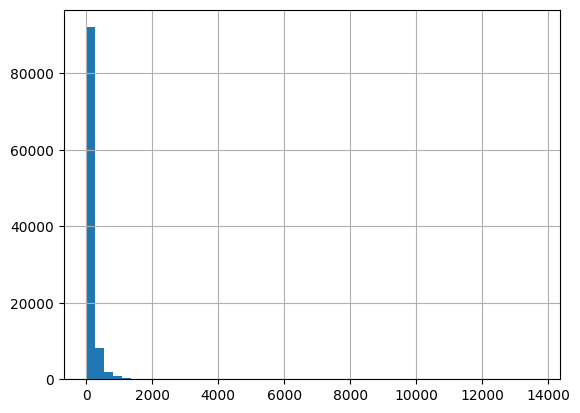

In [96]:
order_payments["payment_value"].hist(bins=50)

<Axes: >

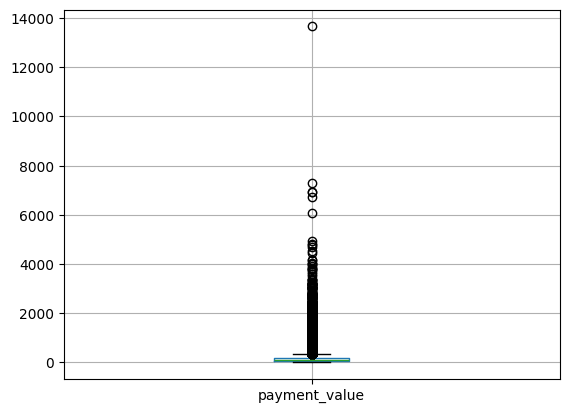

In [99]:
order_payments.boxplot(column="payment_value")  

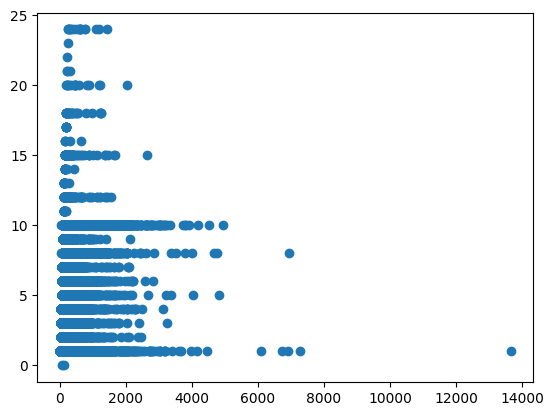

In [100]:
plt.scatter(order_payments["payment_value"], order_payments["payment_installments"])

In [101]:
Q1 = order_payments['payment_value'].quantile(0.25)
Q3 = order_payments['payment_value'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = order_payments[(order_payments['payment_value'] < lower_bound) | (order_payments['payment_value'] > upper_bound)]

In [102]:
outliers.shape

(7981, 5)

In [103]:
order_payments.shape

(103883, 5)

In [ ]:
outliers

The `payment_value` distribution is right-skewed, with ~7.6% of observations identified
as high-value outliers. These values are retained, as they likely represent legitimate
high-spend orders. Downstream analysis uses transformations or caps where needed to
control influence without removing valid customer behavior.


In [104]:
order_payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [105]:
order_payments_final = order_payments.copy()

In [106]:
write_parquet(order_payments_final, project_root / "data" / "interim" / "order_payments_final.parquet")